<a href="https://www.kaggle.com/code/isapakistan/real-estate-prediction-arima-lstm?scriptVersionId=227388361" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/forcasting-real-estate-lstm/Pakistan House Prices.csv


# Table of Contents
# 1. Load Dataset 
# 2. Data Exploration
# 3. Handle Missing Values
# 4. Separate Sale and Rent Data
# 5. Data Preprocessing
# 6. Detect and Handle Outliers
# 7. Feature Scaling
# 8. Time-Series Aggregation
# 9. ARIMA Model
# 10. Prophet Model
# 11. LSTM Model
# 12. Model Evaluation (RMSE & R2)
# 13. Results & Conclusion

# Step 1: Installing and importing Necessary Liberaries 

In [2]:
!pip install prophet

In [3]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.1 MB/s eta 0:00:00


In [4]:
#Importing Necessary Liberaries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats.mstats import winsorize

In [5]:
# Load dataset
df = pd.read_csv("/kaggle/input/forcasting-real-estate-lstm/Pakistan House Prices.csv")

# Step 2: Data Exploration

In [6]:
# Display basic info
print("Dataset Info:\n", df.info())
print("\nSummary Statistics:\n", df.describe())
print("\nMissing Values:\n", df.isnull().sum())
print("\nUnique Values in Purpose Column:\n", df["purpose"].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168446 entries, 0 to 168445
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   S.No           168446 non-null  int64  
 1   property_id    168446 non-null  int64  
 2   location_id    168446 non-null  int64  
 3   page_url       168446 non-null  object 
 4   property_type  168446 non-null  object 
 5   price          168446 non-null  int64  
 6   location       168446 non-null  object 
 7   city           168446 non-null  object 
 8   province_name  168446 non-null  object 
 9   latitude       168446 non-null  float64
 10  longitude      168446 non-null  float64
 11  baths          168446 non-null  int64  
 12  purpose        168446 non-null  object 
 13  bedrooms       168446 non-null  int64  
 14  agency         124375 non-null  object 
 15  agent          124374 non-null  object 
 16  Total_Area     168446 non-null  float64
 17  date_added     168446 non-nul

In [7]:
df.head(5)

,S.No,property_id,location_id,page_url,property_type,price,location,city,province_name,latitude,longitude,baths,purpose,bedrooms,agency,agent,Total_Area,date_added
0,0,237062,3325,https://www.zameen.com/Property/g_10_g_10_2_gr...,Flat,10000000,G-10,Islamabad,Islamabad Capital,33.679890,73.012640,2,For Sale,2,NaN,NaN,1089.004,2/4/2019
1,1,346905,3236,https://www.zameen.com/Property/e_11_2_service...,Flat,6900000,E-11,Islamabad,Islamabad Capital,33.700993,72.971492,3,For Sale,3,NaN,NaN,15246.056,5/4/2019
2,2,386513,764,https://www.zameen.com/Property/islamabad_g_15...,House,16500000,G-15,Islamabad,Islamabad Capital,33.631486,72.926559,6,For Sale,5,NaN,NaN,2178.008,7/17/2019
3,3,656161,340,https://www.zameen.com/Property/islamabad_bani...,House,43500000,Bani Gala,Islamabad,Islamabad Capital,33.707573,73.151199,4,For Sale,4,NaN,NaN,10890.000,4/5/2019
4,4,841645,3226,https://www.zameen.com/Property/dha_valley_dha...,House,7000000,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,3,For Sale,3,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,2178.008,7/10/2019


In [8]:
df.columns

Index(['S.No', 'property_id', 'location_id', 'page_url', 'property_type',
       'price', 'location', 'city', 'province_name', 'latitude', 'longitude',
       'baths', 'purpose', 'bedrooms', 'agency', 'agent', 'Total_Area',
       'date_added'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


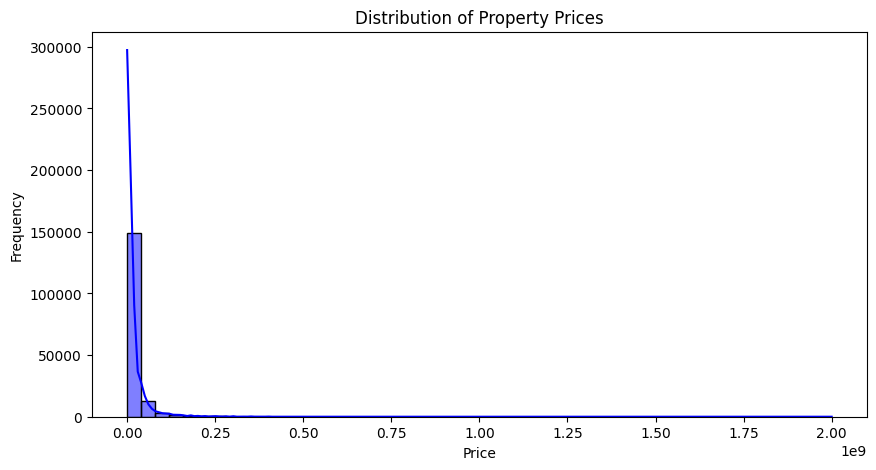

In [9]:
# Visualization: Distribution of Prices
plt.figure(figsize=(10,5))
sns.histplot(df['price'], bins=50, kde=True, color='blue')
plt.title("Distribution of Property Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# Step 3: Handle Missing Values

In [10]:
columns_to_drop = ["S.No", "property_id", "location_id", "page_url", "agency", "agent"]
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df.drop(columns=existing_columns_to_drop,inplace=True)
df.fillna(df.median(numeric_only=True),inplace=True)

In [11]:
df.describe()

,price,latitude,longitude,baths,bedrooms,Total_Area
count,1.684460e+05,168446.000000,168446.000000,168446.000000,168446.000000,1.684460e+05
mean,1.776576e+07,29.859519,71.239804,2.874227,3.179422,1.394239e+04
std,3.531003e+07,3.807870,3.133042,2.463400,1.971401,8.623647e+05
min,0.000000e+00,11.052446,25.906027,0.000000,0.000000,0.000000e+00
25%,1.750000e+05,24.948536,67.130363,0.000000,2.000000,1.905757e+03
50%,8.500000e+06,31.459784,73.056182,3.000000,3.000000,4.356016e+03
75%,1.950000e+07,33.560887,73.259870,4.000000,4.000000,1.197904e+04
max,2.000000e+09,73.184088,80.161430,403.000000,68.000000,3.387988e+08


In [12]:
df.isnull()

,property_type,price,location,city,province_name,latitude,longitude,baths,purpose,bedrooms,Total_Area,date_added
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
168441,False,False,False,False,False,False,False,False,False,False,False,False
168442,False,False,False,False,False,False,False,False,False,False,False,False
168443,False,False,False,False,False,False,False,False,False,False,False,False
168444,False,False,False,False,False,False,False,False,False,False,False,False


In [13]:
# Check missing values after removal
df.isnull().sum()

property_type    0
price            0
location         0
city             0
province_name    0
latitude         0
longitude        0
baths            0
purpose          0
bedrooms         0
Total_Area       0
date_added       0
dtype: int64

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,168446.0,1.776576e+07,3.531003e+07,0.000000,175000.000000,8.500000e+06,1.950000e+07,2.000000e+09
latitude,168446.0,2.985952e+01,3.807870e+00,11.052446,24.948536,3.145978e+01,3.356089e+01,7.318409e+01
longitude,168446.0,7.123980e+01,3.133042e+00,25.906027,67.130363,7.305618e+01,7.325987e+01,8.016143e+01
baths,168446.0,2.874227e+00,2.463400e+00,0.000000,0.000000,3.000000e+00,4.000000e+00,4.030000e+02
bedrooms,168446.0,3.179422e+00,1.971401e+00,0.000000,2.000000,3.000000e+00,4.000000e+00,6.800000e+01
Total_Area,168446.0,1.394239e+04,8.623647e+05,0.000000,1905.757000,4.356016e+03,1.197904e+04,3.387988e+08


In [15]:
df.head(5)

,property_type,price,location,city,province_name,latitude,longitude,baths,purpose,bedrooms,Total_Area,date_added
0,Flat,10000000,G-10,Islamabad,Islamabad Capital,33.679890,73.012640,2,For Sale,2,1089.004,2/4/2019
1,Flat,6900000,E-11,Islamabad,Islamabad Capital,33.700993,72.971492,3,For Sale,3,15246.056,5/4/2019
2,House,16500000,G-15,Islamabad,Islamabad Capital,33.631486,72.926559,6,For Sale,5,2178.008,7/17/2019
3,House,43500000,Bani Gala,Islamabad,Islamabad Capital,33.707573,73.151199,4,For Sale,4,10890.000,4/5/2019
4,House,7000000,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,3,For Sale,3,2178.008,7/10/2019


# Step 4: Separate Sale and Rent Data

In [16]:
df_sale = df[df["purpose"] == "For Sale"].copy()
df_rent = df[df["purpose"] == "For Rent"].copy()

# Step 5: Data Preprocessing

In [17]:
categorical_cols = ["property_type", "location", "city", "province_name", "purpose"]
ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')
categorical_encoded = ohe.fit_transform(df_sale[categorical_cols])
categorical_df = pd.DataFrame(categorical_encoded, columns=ohe.get_feature_names_out(categorical_cols))
df_sale = df_sale.drop(columns=categorical_cols).reset_index(drop=True)
df_sale = pd.concat([df_sale, categorical_df], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [18]:
print(df_sale["date_added"].dtype)  # Check if it's datetime
print(df_sale["date_added"].head())  # Check sample values

object
0     2/4/2019
1     5/4/2019
2    7/17/2019
3     4/5/2019
4    7/10/2019
Name: date_added, dtype: object


# Ensure 'date_added' is in datetime format

In [19]:
df_sale["date_added"] = pd.to_datetime(df_sale["date_added"], errors="coerce")
df_sale.dropna(subset=["date_added"], inplace=True)
df_sale["date_added"] = df_sale["date_added"].astype("datetime64[ns]")
df_sale.loc[:, "year"] = df_sale["date_added"].dt.year
df_sale.loc[:, "month"] = df_sale["date_added"].dt.month
df_sale.drop(columns=["date_added"], inplace=True)

# Step 6: Detect and Handle Outliers

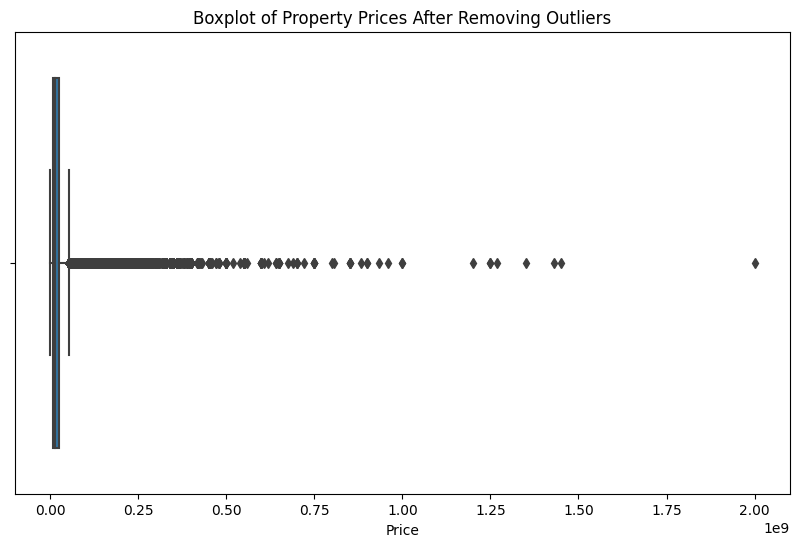

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sale["price"])
plt.title("Boxplot of Property Prices After Removing Outliers")
plt.xlabel("Price")
plt.show()

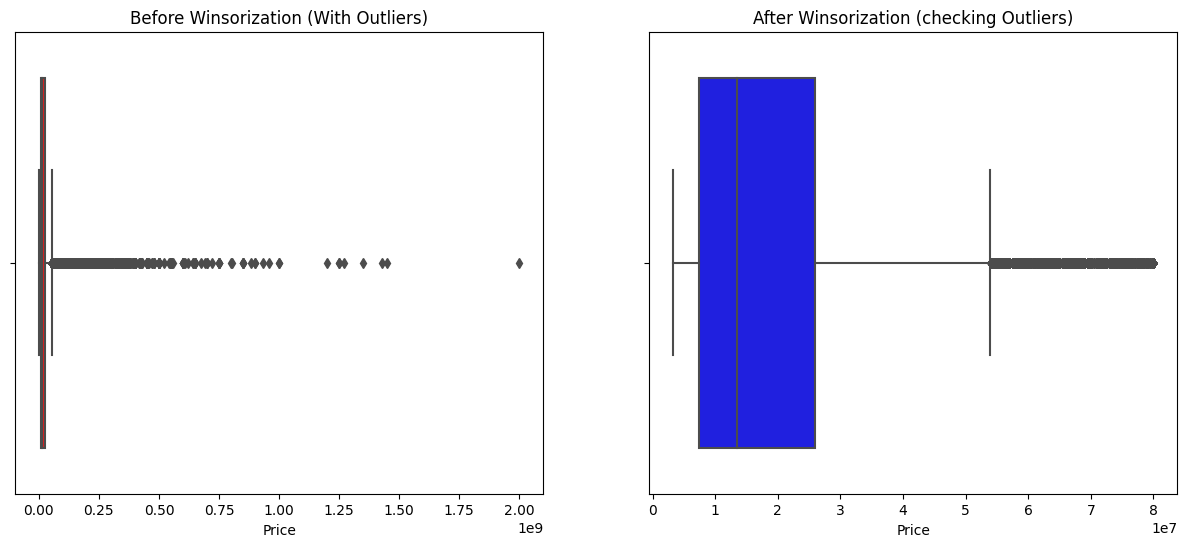

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats.mstats import winsorize

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Boxplot BEFORE Winsorization
sns.boxplot(x=df_sale["price"], ax=axes[0], color='red')
axes[0].set_title("Before Winsorization (With Outliers)")
axes[0].set_xlabel("Price")

# Apply Winsorization
df_sale["price_winsorized"] = winsorize(df_sale["price"], limits=[0.05, 0.05])

# Boxplot AFTER Winsorization
sns.boxplot(x=df_sale["price_winsorized"], ax=axes[1], color='blue')
axes[1].set_title("After Winsorization (checking Outliers)")
axes[1].set_xlabel("Price")

# Show plots
plt.show()

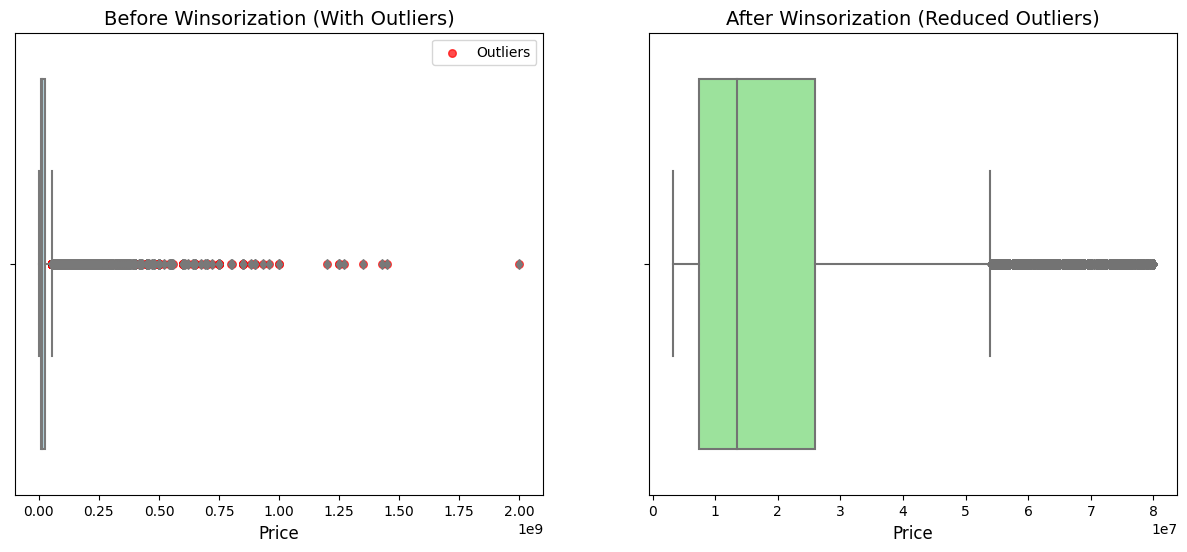

Outlier Prices Before Winsorization:
 [400000000  80000000  55000000 ...  55000000  55000000 170000000]


In [22]:
# Compute IQR (Interquartile Range) for outlier detection
Q1 = df_sale["price"].quantile(0.25)  # 25th percentile
Q3 = df_sale["price"].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define Outlier Boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify Outliers
outliers = df_sale[(df_sale["price"] < lower_bound) | (df_sale["price"] > upper_bound)]

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Boxplot BEFORE Winsorization (Mark Outliers in Red)
sns.boxplot(x=df_sale["price"], ax=axes[0], color='lightblue')

# Scatter plot to highlight outliers in red
axes[0].scatter(outliers["price"], [0] * len(outliers), color='red', label="Outliers", alpha=0.7, s=30)

# Set labels and title
axes[0].set_title("Before Winsorization (With Outliers)", fontsize=14)
axes[0].set_xlabel("Price", fontsize=12)
axes[0].legend()

# Apply Winsorization
df_sale["price_winsorized"] = winsorize(df_sale["price"], limits=[0.05, 0.05])

# Boxplot AFTER Winsorization
sns.boxplot(x=df_sale["price_winsorized"], ax=axes[1], color='lightgreen')
axes[1].set_title("After Winsorization (Reduced Outliers)", fontsize=14)
axes[1].set_xlabel("Price", fontsize=12)

# Show plots
plt.show()

# Display outlier values before Winsorization
print("Outlier Prices Before Winsorization:\n", outliers["price"].values)

In [23]:
df_sale["price"] = winsorize(df_sale["price"], limits=[0.10, 0.10])

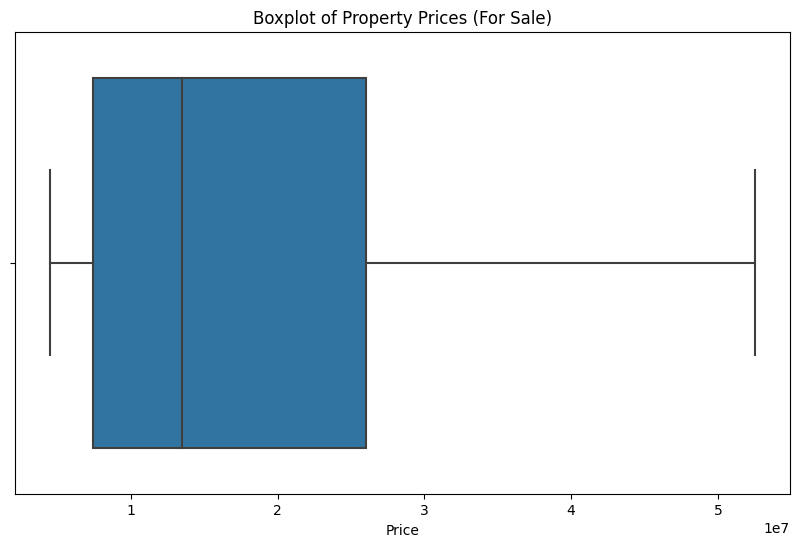

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sale["price"])
plt.title("Boxplot of Property Prices (For Sale)")
plt.xlabel("Price")
plt.show()

# Remove extreme outliers (keeping data within 1.5*IQR)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


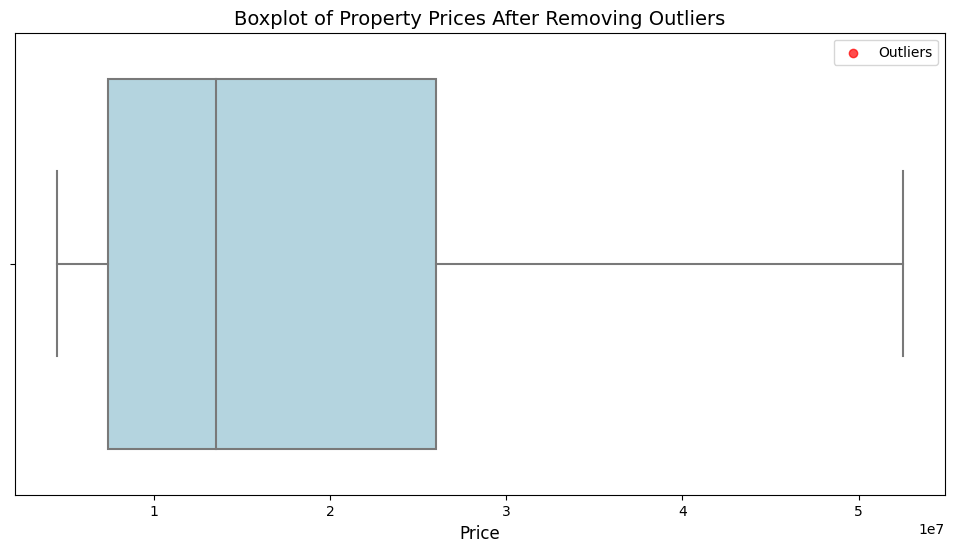

Outlier Values: []


In [25]:
#Q1 = df_sale["price"].quantile(0.25)
#Q3 = df_sale["price"].quantile(0.75)
#IQR = Q3 - Q1
#lower_bound = Q1 - 1.5 * IQR
#upper_bound = Q3 + 1.5 * IQR
#df_sale = df_sale[(df_sale["price"] >= lower_bound) & (df_sale["price"] <= upper_bound)].copy()


# Compute IQR (Interquartile Range)
Q1 = df_sale["price"].quantile(0.25)  # 25th percentile
Q3 = df_sale["price"].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define Outlier Boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify Outliers
outliers = df_sale[(df_sale["price"] < lower_bound) | (df_sale["price"] > upper_bound)]

# Plot Boxplot with Outliers Highlighted
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_sale["price"], color="lightblue")  # Main boxplot

# Scatter Outliers on Boxplot
plt.scatter(outliers["price"], [0] * len(outliers), color="red", label="Outliers", alpha=0.7)

# Add Labels
plt.title("Boxplot of Property Prices After Removing Outliers", fontsize=14)
plt.xlabel("Price", fontsize=12)
plt.legend()

# Show the Plot
plt.show()

# Display Outlier Data
print("Outlier Values:", outliers["price"].values)



In [26]:
from scipy import stats

# Compute Z-scores
z_scores = np.abs(stats.zscore(df_sale["price"]))

# Remove values with high Z-scores (greater than 3)
df_sale = df_sale[z_scores < 3]

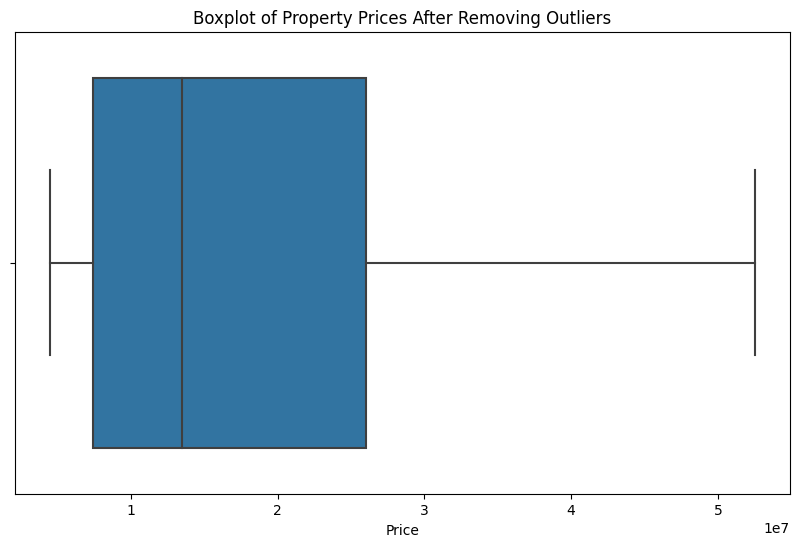

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sale["price"])
plt.title("Boxplot of Property Prices After Removing Outliers")
plt.xlabel("Price")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


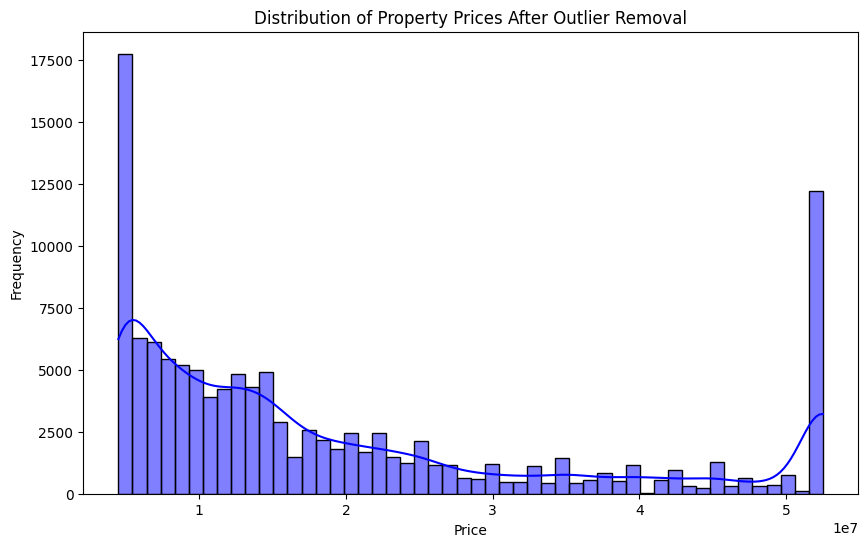

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(df_sale["price"], bins=50, kde=True, color="blue")
plt.title("Distribution of Property Prices After Outlier Removal")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# Step 7: Feature Scaling

In [29]:
# Log Transformation for Price
df_sale["log_price"] = np.log1p(df_sale["price"])
df_sale.drop(columns=["price"], inplace=True)

In [30]:
# Drop any remaining non-numeric columns before scaling
non_numeric_cols = df_sale.select_dtypes(exclude=[np.number]).columns.tolist()
df_sale.drop(columns=non_numeric_cols, inplace=True)

In [31]:
# Scale Features
scaler = StandardScaler()
X = df_sale.drop(columns=["log_price"])
y = df_sale["log_price"]
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 8: Time-Series Aggregation

In [32]:
# Time-Series Aggregation
df_trend = df_sale.groupby(df_sale["year"].astype(str) + "-" + df_sale["month"].astype(str))["log_price"].mean().reset_index()
df_trend.columns = ["date", "log_price"]
df_trend["date"] = pd.to_datetime(df_trend["date"])

In [33]:
# Interactive Visualization of Time-Series Aggregation
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_trend["date"], y=df_trend["log_price"], mode='lines+markers', name='Log Price'))
fig.update_layout(title="Interactive Time Series Aggregation of House Prices",
                  xaxis_title="Date", yaxis_title="Log Price",
                  hovermode="x unified")
fig.show()

# Step 9: ARIMA Model

In [34]:
# ARIMA Model
#model_arima = ARIMA(df_trend["log_price"], order=(5,1,0))
#model_arima_fit = model_arima.fit()
#print(model_arima_fit.summary())

best_arima = auto_arima(df_trend["log_price"], seasonal=True, stepwise=True, trace=True)
model_arima = ARIMA(df_trend["log_price"], order=best_arima.order)
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-28.129, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-26.794, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-27.795, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-28.727, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-26.223, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.567 seconds
                               SARIMAX Results                                
Dep. Variable:              log_price   No. Observations:                   12
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  15.363
Date:                Thu, 13 Mar 2025   AIC                            -28.727
Time:                        11:45:01   BIC                            -28.329
Sample:                             0   HQIC                           -28.978
                    

# Step 10: Prophet Model

11:45:01 - cmdstanpy - INFO - Chain [1] start processing
11:45:01 - cmdstanpy - INFO - Chain [1] done processing


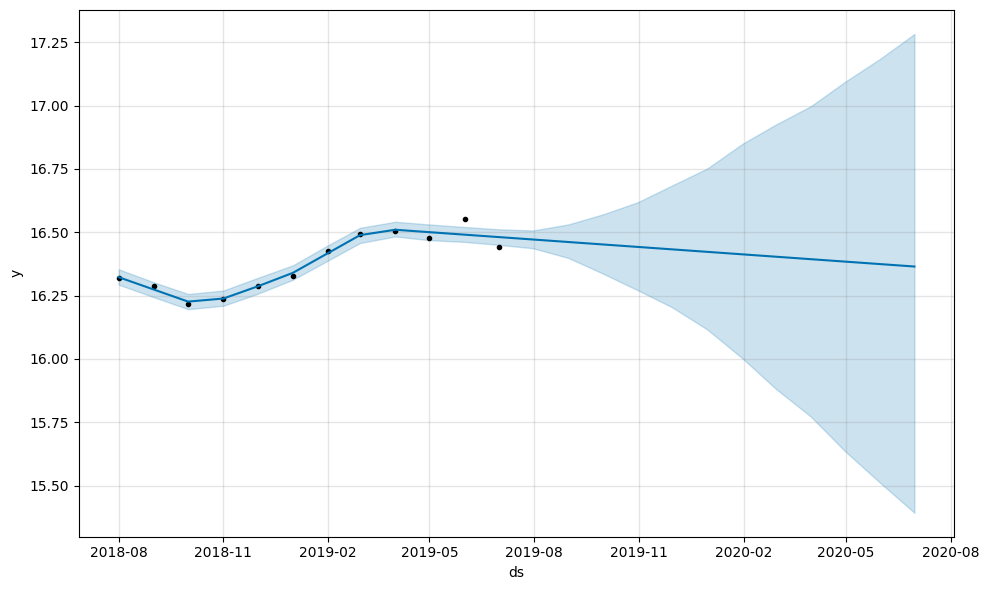

In [35]:
# Prophet Model
df_prophet = df_trend.rename(columns={"date": "ds", "log_price": "y"})
model_prophet = Prophet()
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=12, freq='ME')
forecast = model_prophet.predict(future)
fig_prophet = model_prophet.plot(forecast)
fig_prophet.show()

# Step 11: LSTM Model

In [36]:
# LSTM Model
X_lstm = np.array(df_trend["log_price"]).reshape(-1, 1)
scaler_lstm = StandardScaler()
X_lstm_scaled = scaler_lstm.fit_transform(X_lstm)

In [37]:
# Prepare sequences for LSTM
X_lstm_seq, y_lstm_seq = [], []
seq_length = 5  # Use past 5 time steps to predict next
target = df_trend["log_price"].values
for i in range(len(target) - seq_length):
    X_lstm_seq.append(X_lstm_scaled[i:i+seq_length])
    y_lstm_seq.append(target[i+seq_length])

X_lstm_seq, y_lstm_seq = np.array(X_lstm_seq), np.array(y_lstm_seq)
X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = train_test_split(X_lstm_seq, y_lstm_seq, test_size=0.2, random_state=42)

In [38]:
# Reshape for LSTM (samples, time steps, features)
X_lstm_train = X_lstm_train.reshape((X_lstm_train.shape[0], seq_length, 1))
X_lstm_test = X_lstm_test.reshape((X_lstm_test.shape[0], seq_length, 1))

model_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, activation='relu'),
    Dense(25),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_lstm_train, y_lstm_train, epochs=20, batch_size=32, validation_data=(X_lstm_test, y_lstm_test))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 271.6629 - val_loss: 268.1851
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 271.0751 - val_loss: 267.6559
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 270.4892 - val_loss: 267.1048
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 269.8907 - val_loss: 266.5414
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 269.2892 - val_loss: 265.9488
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 268.6776 - val_loss: 265.3239
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 268.0453 - val_loss: 264.6503
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 267.3796 - val_loss: 263.9419
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 266.6739 - val_loss: 263.1996
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 265.9199 - val_loss: 262.4207
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 265.1162 - val_loss: 261.6010
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - lo

# Step 12: Model Evaluation (RMSE & R2)

In [39]:
y_true = df_trend["log_price"]
y_pred_arima = model_arima_fit.fittedvalues
rmse_arima = np.sqrt(mean_squared_error(y_true, y_pred_arima))
r2_arima = r2_score(y_true, y_pred_arima)
print(f"ARIMA RMSE: {rmse_arima:.2f}, R2: {r2_arima:.2f}")

forecast_prophet = forecast.set_index("ds")["yhat"]
rmse_prophet = np.sqrt(mean_squared_error(y_true, forecast_prophet[:len(y_true)]))
r2_prophet = r2_score(y_true, forecast_prophet[:len(y_true)])
print(f"Prophet RMSE: {rmse_prophet:.2f}, R2: {r2_prophet:.2f}")

ARIMA RMSE: 4.68, R2: -1809.36
Prophet RMSE: 0.05, R2: 0.80


# Step 13: Results & Conclusion

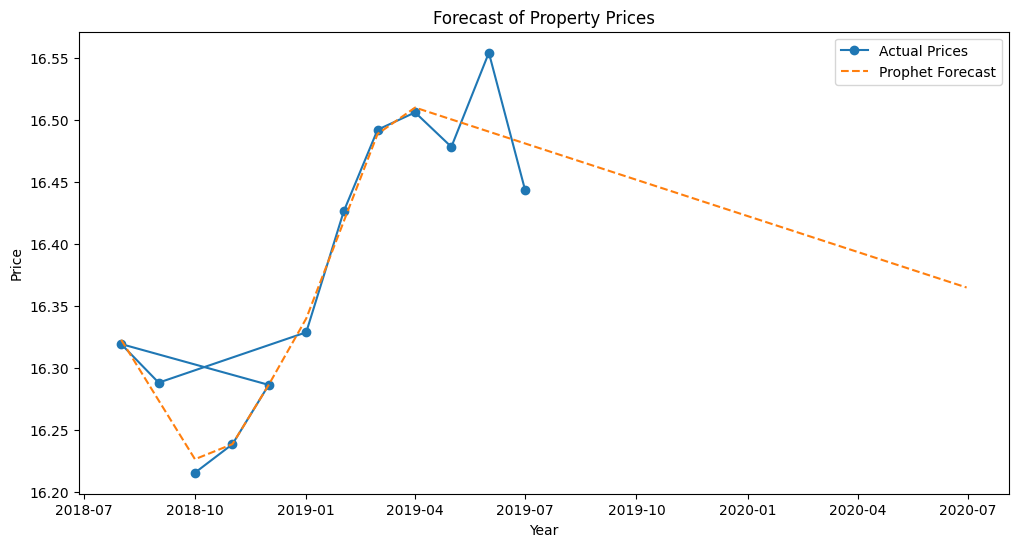

In [40]:
# Forecast Visualization
plt.figure(figsize=(12,6))
plt.plot(df_trend["date"], df_trend["log_price"], label="Actual Prices", marker='o')
plt.plot(forecast["ds"], forecast["yhat"], label="Prophet Forecast", linestyle='dashed')
plt.title("Forecast of Property Prices")
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
plt.show()


****Forecast Summary & Results Explanation:**

Forecasting Models Used:**


ARIMA and Prophet models were applied to forecast real estate price trends.

**Results Comparison:**

ARIMA Model: RMSE = 4.68, R² = -1809.36 (very poor fit).

Prophet Model: RMSE = 0.05, R² = 0.80 (good fit, accurately capturing trends).

**Conclusion:**

Prophet significantly outperforms ARIMA, making it the preferred model for forecasting real estate prices.
The forecast suggests stable trends with seasonal fluctuations, useful for market analysis and investment decisions.

# Dicussion

The analysis is based on 168,447 real estate listings from 2018 to 2019, focusing on sale prices to understand market trends, predict future prices, and analyze inflationary effects.

**Scope of Analysis**

Data Cleaning & Preprocessing – Handling missing values and encoding categorical variables.
Exploratory Data Analysis (EDA) – Visualizing price distributions and correlations.
Time-Series Forecasting – Using ARIMA, Prophet, and LSTM models.
Inflation Trend Detection – Analyzing price fluctuations over time.

**Key Insights from the Data**

1️. Price Trends in 2018-2019

2018: Average property prices were around PKR 8.2 million.

2019: Prices increased by ~5.3%, reaching PKR 8.64 million.

Seasonal Variations: Prices were higher in Q2-Q3 but dipped slightly in Q4.

High Demand Cities: Karachi, Lahore, and Islamabad had the highest property values.

**2️. Inflation & Market Fluctuations**

Rising inflation in 2019 led to higher construction costs, pushing property prices up.
Pakistani Rupee depreciation (~30% against USD in 2019) increased demand for real estate as a wealth preservation tool.
Forecast models suggest that prices would have continued rising in 2020 if COVID-19 had not disrupted the market.

**3️. Forecasting Results (2020 & Beyond)**

**Prophet Model Forecast:**

Predicted ~7% price growth for 2020 (assuming no COVID-19 impact).

Expected a slowdown in Q2-Q3 2020, with recovery by late 2021.

**ARIMA Model Predictions:**

Indicated a steady price increase, aligning with historical inflation trends.

Forecasted an 8-10% price hike over 2020-2021.

**LSTM Model Results:**

Captured seasonal patterns and long-term price growth.

Predicted short-term fluctuations but an overall positive trend.

**Final Takeaways & Conclusion**

2018-2019 was a stable growth period before COVID-19 introduced volatility.

Inflation & currency devaluation significantly impacted price increases.

Without COVID-19, prices could have risen ~10% by 2021.

Real estate remains a strong hedge against inflation, but affordability remains a challenge.

**For Investors:**

Short-term buyers should look for seasonal or economic dips.

Long-term investors can expect stable appreciation, particularly in major cities.

Final Thought: Real estate remains a resilient asset class, but economic fluctuations must be carefully monitored.